In [1]:
import numpy as np
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image

In [2]:
time.sleep(13*3600)

In [3]:
# Set Important Values

data = '/data/dww78/mini_inat/'
gpu = 2
torch.cuda.set_device(gpu)
workers = 8
epoch = 10
start_epoch = 0
vbity = 50
esize = 4

way = 20
evalway = 5
bshot = 10
trainshot = 20
testshot = 10
foldshot = 20

In [4]:
# Load Training/Testing Data
threshold = .15
d_train = torch.load(data+'train_boxes.pth')
d_test = torch.load(data+'val_boxes.pth')
d_boxes = torch.load(data+'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, pathdict, boxdict, transform, size, msize, flipping, masking):
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    w,h = p.size
    p = p.resize((size, size), Image.BILINEAR)
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    if masking:
        mask = np.zeros((h,w))
        boxes = pathdict[path]
        for b in boxes:
            box = boxdict[b]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            if not flip or not flipping:
                mask[ymin:ymax, xmin:xmax] = 1
            else:
                mask[ymin:ymax, w-xmax:w-xmin] = 1
        mask = resize(mask, (msize,msize), mode='constant', cval=0, anti_aliasing=False)
        t = [t, (torch.FloatTensor(mask-threshold).sign()/2+.5).unsqueeze(0)]
    return t

class FoldSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
        for key in trackdict:
            np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        while len(trackdict.keys()) >= self.way:
            pcount = np.array([len(trackdict[k]) for k in list(trackdict.keys())])
            cats = np.random.choice(list(trackdict.keys()), size=self.way, replace=False, p=pcount/sum(pcount))
            for cat in cats:
                for _ in range(bshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(foldshot):
                    idlist.append(trackdict[cat].pop())
                if len(trackdict[cat]) < bshot+foldshot:
                    trackdict.pop(cat)
            yield idlist
            idlist = []

class ProtoSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
        for key in trackdict:
            np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        while len(trackdict.keys()) >= self.way:
            pcount = np.array([len(trackdict[k]) for k in list(trackdict.keys())])
            cats = np.random.choice(list(trackdict.keys()), size=self.way, replace=False, p=pcount/sum(pcount))
            for cat in cats:
                for _ in range(bshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(trainshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(testshot):
                    idlist.append(trackdict[cat].pop())
                if len(trackdict[cat]) < bshot+trainshot+testshot:
                    trackdict.pop(cat)
            yield idlist
            idlist = []

train_dataset = datasets.ImageFolder(
    data+'train', 
    loader = lambda x: load_transform(x, d_train, d_boxes, transform, 84, 21, True, True))
test_dataset = datasets.ImageFolder(
    data+'val',
    loader = lambda x: load_transform(x, d_test, d_boxes, transform, 84, 21, False, True))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = FoldSampler(train_dataset, way),
    num_workers = workers,
    pin_memory = True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset, evalway),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')
print(len(train_dataset.classes), len(test_dataset.classes))

Data loaded!
908 227


In [5]:
# Make Models

class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class PROTO(nn.Module):
    def __init__(self):
        super(PROTO, self).__init__()
        self.process = nn.Sequential(
            Block(4,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.AvgPool2d(10)
        )
        
    def forward(self, inp):
        return self.process(inp).view(inp.size(0),-1)
        
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, support, query, way):
        assert support.size(0)%way == 0,"Error: classes are not the same size!"
        shot = support.size(0)//way
        support = support.view(way,shot,-1)
        centroids = torch.mean(support, 1).view(support.size(0),-1)
        if self.training:
            centroids = centroids.unsqueeze(0).unsqueeze(0) # w 1 1 d
            support = support.unsqueeze(2) # w s 1 d
            eye = torch.eye(way).unsqueeze(1).unsqueeze(-1).cuda()/shot # w 1 w 1
            rescaler = (torch.eye(way)/(shot-1) + torch.ones(way,way)).unsqueeze(1).unsqueeze(-1).cuda()
            realc = (centroids - support*eye)*rescaler # w s w d
            distmat = torch.sum((realc-support)**2, -1).squeeze().view(way*shot,way).neg() # ws w
        else:
            distmat = torch.sum((centroids.unsqueeze(0)-query.unsqueeze(1))**2,2).squeeze().neg()
        probs = self.sm(distmat)
        return probs
    
class bPROTO(nn.Module):
    def __init__(self):
        super(bPROTO, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            Block(64,64)
        )
        
    def forward(self, inp):
        return self.process(inp)
    
class cPredictor(nn.Module):
    def __init__(self):
        super(cPredictor, self).__init__()
        
    def forward(self, inp, masks, way, shot):
        support = inp.unsqueeze(-1) # B 64 21 21 1
        m = masks # B 1 21 21
        c = torch.stack([1-m, m], dim=-1) # B 1 21 21 2     (Positive class corresponds to index/label 1)
        c = (c*support).contiguous().view(way,shot,inp.size(1),inp.size(2)*inp.size(3),2).mean(3).mean(1) # W 64 2
        return c
        
class bPredictor(nn.Module):
    def __init__(self):
        super(bPredictor, self).__init__()
        self.sm = nn.Softmax(dim=-1)
        self.upper = nn.Upsample(size=(84,84), mode='bilinear')
        
    def forward(self, inp, c):
        c = c.unsqueeze(2).unsqueeze(2).unsqueeze(1) # W 1 64 1 1 2
        query = inp.view(c.size(0), -1, inp.size(1), inp.size(2), inp.size(3), 1) # W S 64 21 21 1
        distmat = ((c-query)**2).sum(2).neg().view(inp.size(0), inp.size(2), inp.size(3), 2) # B 21 21 2
        probs = self.sm(distmat)[:,:,:,1]
        return self.upper(probs.unsqueeze(1))
    
smodel = [PROTO().cuda() for i in range(esize)]
bmodel = bPROTO()
bmodel.load_state_dict(torch.load('detectors/saved_models/box_predictors_fixed.pth')[0])
bmodel.cuda()
predictor = Predictor().cuda()
cpredictor = cPredictor().cuda()
bpredictor = bPredictor().cuda()
soptimizer = [optim.Adam(m.parameters(), lr=.001) for m in smodel]
sscheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in soptimizer]
criterion = nn.NLLLoss().cuda()
cudnn.benchmark = True

nweights = sum([i.numel() for i in list(smodel[0].parameters())])
print(nweights," parameters in each neural net.")

113664  parameters in each neural net.


In [6]:
# Define the Procedures

def train(train_loader, epoch, gpu, vbity):
    for model in smodel:
        model.train()
    bmodel.eval()
    predictor.train()
    targ = Variable(torch.LongTensor([i//foldshot for i in range(foldshot*way)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    for i, ((inp, m), _) in enumerate(train_loader):
        inp = Variable(inp).cuda(device = gpu, async=True)
        m = Variable(m).cuda(device = gpu, async=True)
        with torch.no_grad():
            c = cpredictor(bmodel(inp[:way*bshot]), m[:way*bshot], way, bshot).detach()
            masks = bpredictor(bmodel(inp[way*bshot:]), c).detach()
        inp = torch.cat([inp[way*bshot:], masks], dim=1)
        
        for j in range(esize):
            smodel[j].zero_grad()
            out = predictor(smodel[j](inp), None, way)
            loss = criterion(out, targ)
            loss.backward()
            soptimizer[j].step()
        
            allloss[j] += loss.item()
            
        if i%vbity == 0:
            print('%d of approx. 192270'%(i*way*(bshot+foldshot)))
    return [L/i for L in allloss]

def validate(val_loader, gpu, vbity, reps, verbose):
    for model in smodel:
        model.eval()
    bmodel.eval()
    predictor.eval()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*evalway)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    acctracker = [[] for _ in range(esize)]
    for r in range(reps):
        for i, ((inp, m), _) in enumerate(val_loader):
            inp = Variable(inp).cuda(device = gpu, async=True)
            m = Variable(m).cuda(device = gpu, async=True)
            with torch.no_grad():
                c = cpredictor(bmodel(inp[:evalway*bshot]), m[:evalway*bshot], evalway, bshot).detach()
                smasks = bpredictor(bmodel(inp[evalway*bshot:evalway*(bshot+trainshot)]), c).detach()
                qmasks = bpredictor(bmodel(inp[evalway*(bshot+trainshot):]), c).detach()
                masks = torch.cat([smasks,qmasks], dim=0)
                inp = torch.cat([inp[evalway*bshot:], masks], dim=1)

                for j in range(esize):
                    out = predictor(smodel[j](inp[:evalway*trainshot]), smodel[j](inp[evalway*trainshot:]), evalway)
                    loss = criterion(out, targ)
                    allloss[j] += loss.item()
                    _,bins = torch.max(out,1)
                    acc = torch.sum(torch.eq(bins,targ)).item()/testshot/evalway
                    acctracker[j].append(acc)
            if i%vbity == 0 and verbose:
                print('Round %d of %d, %d of approx. 51716'%(r+1, reps, i*evalway*(trainshot+testshot)))
    return [L/i for L in allloss], [np.mean(a) for a in acctracker], [1.96*np.sqrt(np.var(a)/len(a)) for a in acctracker]

print('Ready to go!')

Ready to go!


In [7]:
#                                             RETRAINING

In [8]:
# Load the pretrained models

ts,m,o = torch.load('saved_models/retraining_folded_initial_cpu.torch')
for i in range(esize):
    smodel[i].load_state_dict(m[i])
    soptimizer[i].load_state_dict(o[i])
trainlosses, testlosses, acctracker = ts
# torch.save((ts,[m.state_dict() for m in smodel],[o.state_dict() for o in soptimizer]), 
#            'saved_models/retraining_folded_initial_cpu.torch')

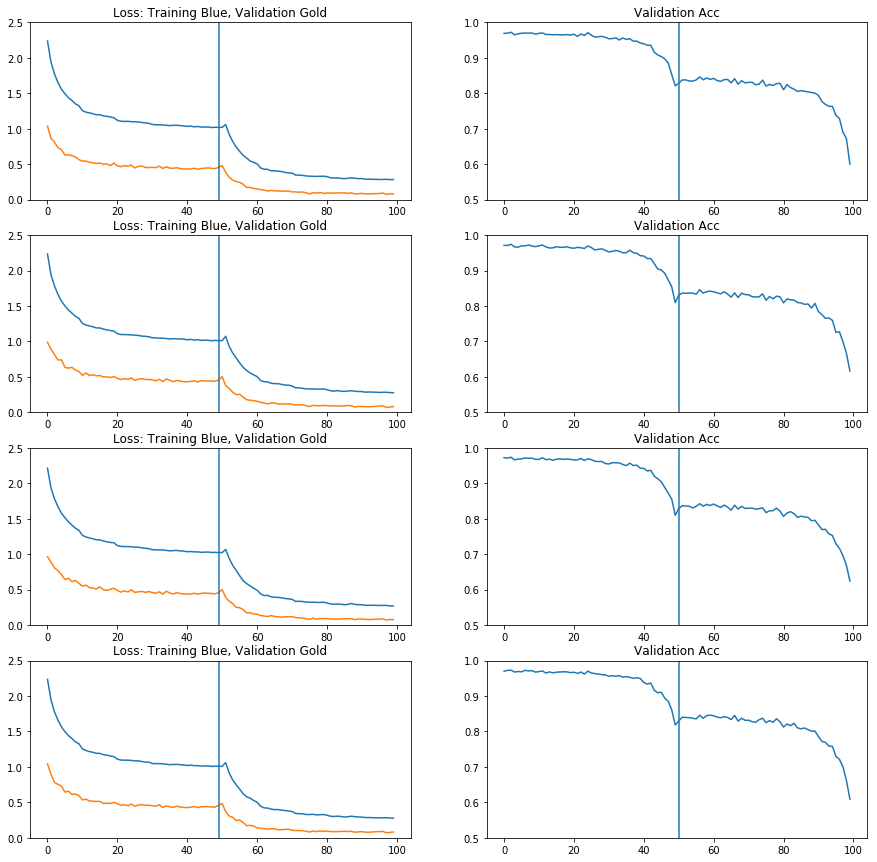

Train loss is: [0.28293340328286903, 0.2774322255713041, 0.26899407374077156, 0.27667021321468666]
Validation accuracy is: [0.9690047393364931, 0.9710900473933649, 0.9723222748815166, 0.9697630331753555]
Validation loss is: [0.08276179265351172, 0.08116330444100597, 0.07599258087361488, 0.08225327750390946]

0.19 hours to completion

0 of approx. 192270
30000 of approx. 192270
60000 of approx. 192270
90000 of approx. 192270
120000 of approx. 192270
150000 of approx. 192270
180000 of approx. 192270
9.42489046825303 hours total
Model 0 final score: 96.88 +- 0.16
Model 1 final score: 96.93 +- 0.16
Model 2 final score: 97.00 +- 0.15
Model 3 final score: 96.94 +- 0.16


In [9]:
# Do the Thing!

start = time.time()
# trainlosses, testlosses, acctracker = [[] for _ in range(esize)],[[] for _ in range(esize)],[[] for _ in range(esize)]
epochs = 5*epoch
trainloss = [t[-1] for t in trainlosses]
for e in range(epochs):
    
    # Evaluate, single pass
    testloss, acc, _ = validate(test_loader, gpu, vbity, 1, True)
    
    # update the precision graph, report
    display.clear_output(wait=True)
    for j in range(esize):
        trainlosses[j].append(trainloss[j])
        testlosses[j].append(testloss[j])
        acctracker[j].append(acc[j])
    pl.figure(1, figsize=(15,15))
    for i in range(esize):
        pl.subplot(esize,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.plot(testlosses[i])
        pl.axvline(x=49)
        pl.ylim((0,2.5))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(esize,2,2*i+2)
        pl.plot(acctracker[i][::-1])
        pl.axvline(x=len(trainlosses[i])-50)
        pl.ylim((0.5,1))
        pl.title("Validation Acc")
    pl.show()
    print("Train loss is: "+str(trainloss)+
            "\nValidation accuracy is: "+str(acc)+
            "\nValidation loss is: "+str(testloss)+"\n")
    
    print("%.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
    
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in sscheduler]
    
    # Train for one epoch
    trainloss = train(train_loader, e, gpu, vbity)
    
print((time.time()-start)/3600, "hours total") 
_, score, conf = validate(test_loader, gpu, vbity, 10, False)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

In [10]:
torch.save([m.cpu().state_dict() for m in smodel], 'saved_models/bpred_partial_fold_retrain_fixed_full.torch')

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

In [ ]:
#                                         EVALUATION ONLY

In [7]:
for i,model in enumerate(smodel):
    model.load_state_dict(torch.load('saved_models/bpred_partial_fold_retrain_fixed.torch')[i])
    model.cuda()
print("Models prepared!")

_, score, conf = validate(test_loader, gpu, vbity, 4, True)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Round 1 of 4, 0 of approx. 51716
Round 1 of 4, 3000 of approx. 51716
Round 1 of 4, 6000 of approx. 51716
Round 1 of 4, 9000 of approx. 51716
Round 1 of 4, 12000 of approx. 51716
Round 1 of 4, 15000 of approx. 51716
Round 1 of 4, 18000 of approx. 51716
Round 1 of 4, 21000 of approx. 51716
Round 1 of 4, 24000 of approx. 51716
Round 1 of 4, 27000 of approx. 51716
Round 1 of 4, 30000 of approx. 51716
Round 2 of 4, 0 of approx. 51716
Round 2 of 4, 3000 of approx. 51716
Round 2 of 4, 6000 of approx. 51716
Round 2 of 4, 9000 of approx. 51716
Round 2 of 4, 12000 of approx. 51716
Round 2 of 4, 15000 of approx. 51716
Round 2 of 4, 18000 of approx. 51716
Round 2 of 4, 21000 of approx. 51716
Round 2 of 4, 24000 of approx. 51716
Round 2 of 4, 27000 of approx. 51716
Round 2 of 4, 30000 of approx. 51716
Round 3 of 4, 0 of approx. 51716
Round 3 of 4, 3000 of approx. 51716
Round 3 of 4, 6000 of approx. 51716
Round 3 of 4, 9000 of approx. 51716
Round 3 of 4, 12000 of approx. 51716
Round 3 of 4, 15000 of